Polar Total Variation Denoising (PDHG)
======================================

This example compares denoising via standard isotropic total
variation (TV) regularization <cite data-cite="rudin-1992-nonlinear"/>
<cite data-cite="goldstein-2009-split"/> and a variant based on local polar
coordinates, as described in <cite data-cite="hossein-2024-total"/>. It solves the
denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is either the isotropic or polar TV regularizer, via the
primal–dual hybrid gradient (PDHG) algorithm.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize import PDHG
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with standard isotropic total variation.

In [4]:
λ_std = 0.8e0
f = loss.SquaredL2Loss(y=y)
g_std = λ_std * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
tau, sigma = PDHG.estimate_parameters(C, ratio=20.0)
solver = PDHG(
    f=f,
    g=g_std,
    C=C,
    tau=tau,
    sigma=sigma,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
print(f"Solving on {device_info()}\n")
solver.solve()
hist_std = solver.itstat_object.history(transpose=True)
x_std = solver.x
print()

Solving on CPU



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  3.84e-01  3.043e+04  2.250e+02  5.692e+01
  10  5.35e-01  2.270e+04  5.944e+01  5.649e+00
  20  5.74e-01  2.120e+04  2.712e+01  2.290e+00
  30  6.13e-01  2.082e+04  1.271e+01  1.149e+00
  40  6.63e-01  2.072e+04  6.011e+00  6.725e-01


  50  7.11e-01  2.068e+04  2.905e+00  4.402e-01
  60  7.48e-01  2.067e+04  1.451e+00  3.144e-01
  70  7.83e-01  2.066e+04  7.695e-01  2.407e-01
  80  8.19e-01  2.065e+04  4.446e-01  1.926e-01
  90  8.57e-01  2.065e+04  2.833e-01  1.608e-01


 100  8.96e-01  2.065e+04  2.007e-01  1.374e-01
 110  9.29e-01  2.065e+04  1.511e-01  1.200e-01
 120  9.61e-01  2.065e+04  1.222e-01  1.058e-01
 130  9.95e-01  2.065e+04  1.005e-01  9.420e-02
 140  1.03e+00  2.065e+04  8.392e-02  8.480e-02
 150  1.06e+00  2.064e+04  7.039e-02  7.701e-02


 160  1.10e+00  2.064e+04  6.164e-02  7.042e-02
 170  1.14e+00  2.064e+04  5.333e-02  6.479e-02
 180  1.18e+00  2.064e+04  4.750e-02  5.953e-02
 190  1.23e+00  2.064e+04  4.117e-02  5.539e-02
 199  1.28e+00  2.064e+04  3.739e-02  5.192e-02



Denoise with polar total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelty as the isotropic case.
λ_plr = 1.2e0
g_plr = λ_plr * functional.L1Norm()

G = linop.PolarGradient(input_shape=x_gt.shape)
D = linop.Diagonal(snp.blockarray([0.3, 1.0]), input_shape=G.shape[0])
C = D @ G

tau, sigma = PDHG.estimate_parameters(C, ratio=20.0)
solver = PDHG(
    f=f,
    g=g_plr,
    C=C,
    tau=tau,
    sigma=sigma,
    maxiter=200,
    itstat_options={"display": True, "period": 10},
)
solver.solve()
hist_plr = solver.itstat_object.history(transpose=True)
x_plr = solver.x
print()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  3.00e-02  3.162e+04  2.250e+02  4.213e+01
  10  1.77e-01  2.364e+04  6.908e+01  9.700e+00
  20  2.37e-01  2.153e+04  3.149e+01  5.146e+00
  30  3.02e-01  2.085e+04  1.564e+01  3.072e+00


  40  3.70e-01  2.057e+04  8.399e+00  1.989e+00
  50  4.27e-01  2.043e+04  4.887e+00  1.386e+00
  60  4.81e-01  2.035e+04  3.065e+00  1.025e+00


  70  5.34e-01  2.030e+04  2.034e+00  7.987e-01
  80  5.87e-01  2.027e+04  1.440e+00  6.476e-01
  90  6.39e-01  2.025e+04  1.065e+00  5.435e-01
 100  6.92e-01  2.024e+04  8.231e-01  4.668e-01


 110  7.45e-01  2.023e+04  6.467e-01  4.092e-01
 120  7.97e-01  2.022e+04  5.214e-01  3.663e-01
 130  8.52e-01  2.022e+04  4.339e-01  3.312e-01
 140  9.15e-01  2.022e+04  3.707e-01  3.023e-01


 150  9.80e-01  2.021e+04  3.258e-01  2.771e-01
 160  1.03e+00  2.021e+04  2.936e-01  2.551e-01
 170  1.09e+00  2.021e+04  2.640e-01  2.359e-01


 180  1.14e+00  2.020e+04  2.340e-01  2.189e-01
 190  1.20e+00  2.020e+04  2.094e-01  2.046e-01
 199  1.25e+00  2.020e+04  1.877e-01  1.940e-01



Compute and print the data fidelity.

In [6]:
for x, name in zip((x_std, x_plr), ("Isotropic", "Polar")):
    df = f(x)
    print(f"Data fidelity for {(name + ' TV'):12}: {df:.2e}   SNR: {metric.snr(x_gt, x):5.2f} dB")

Data fidelity for Isotropic TV: 1.77e+04   SNR:  9.51 dB
Data fidelity for Polar TV    : 1.79e+04   SNR: 11.03 dB


Plot results.

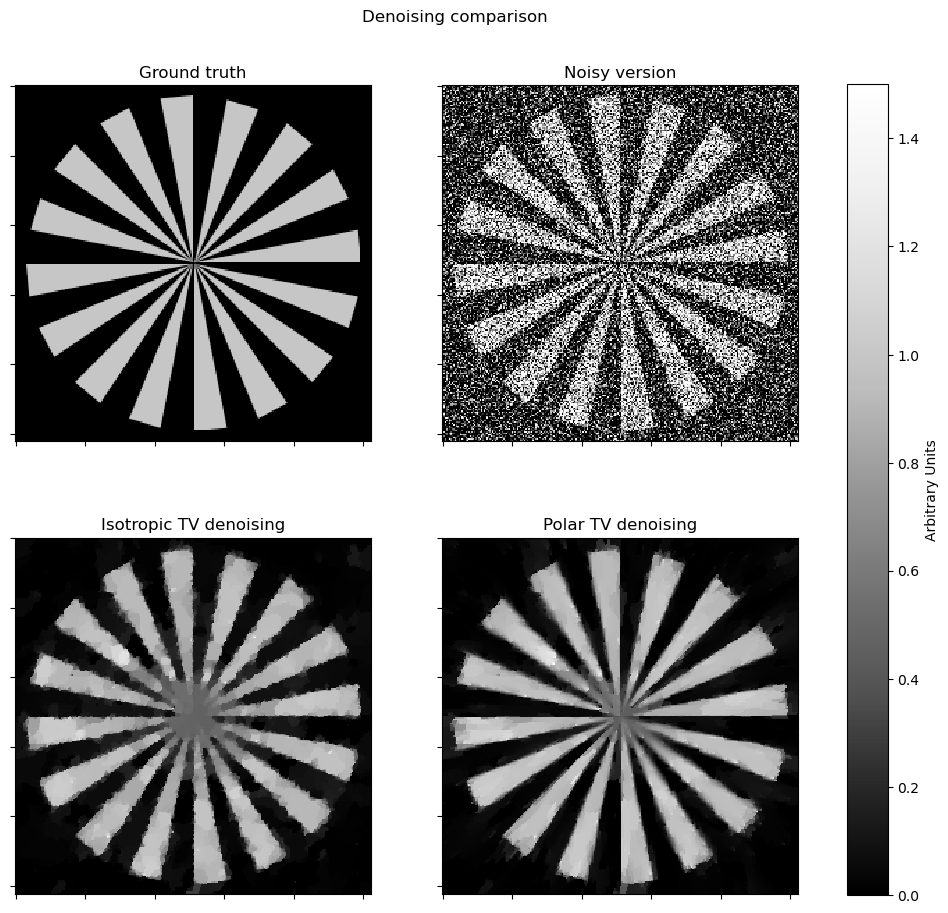

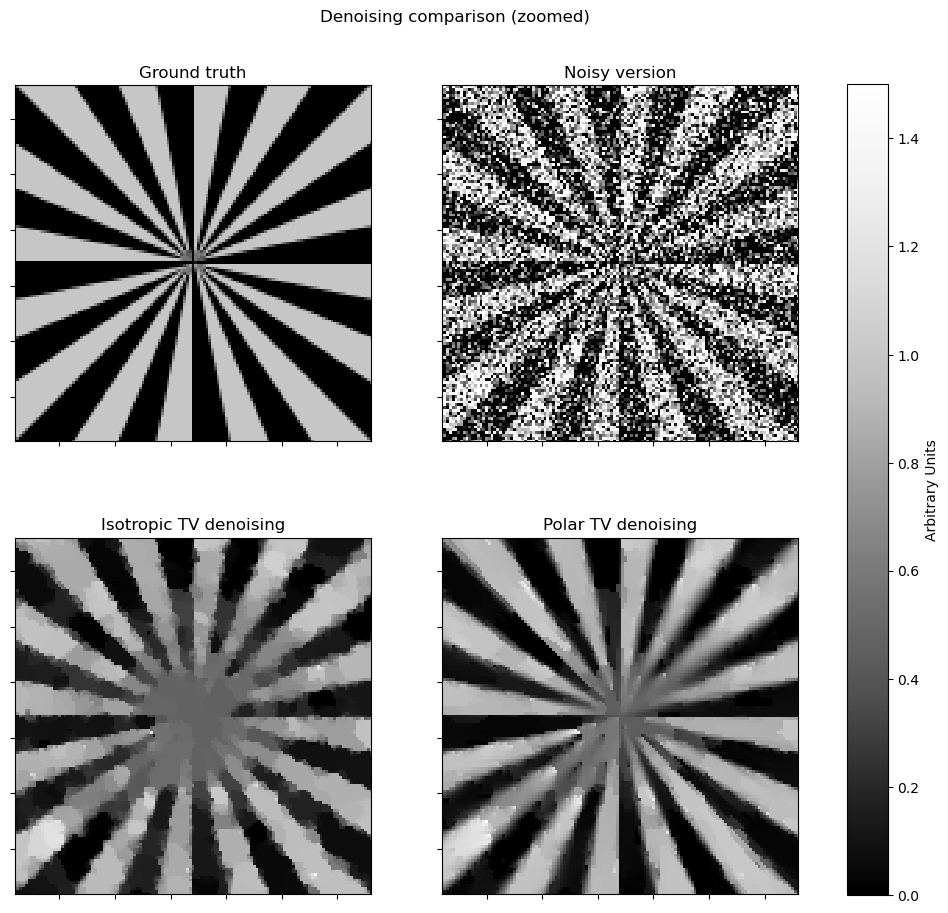

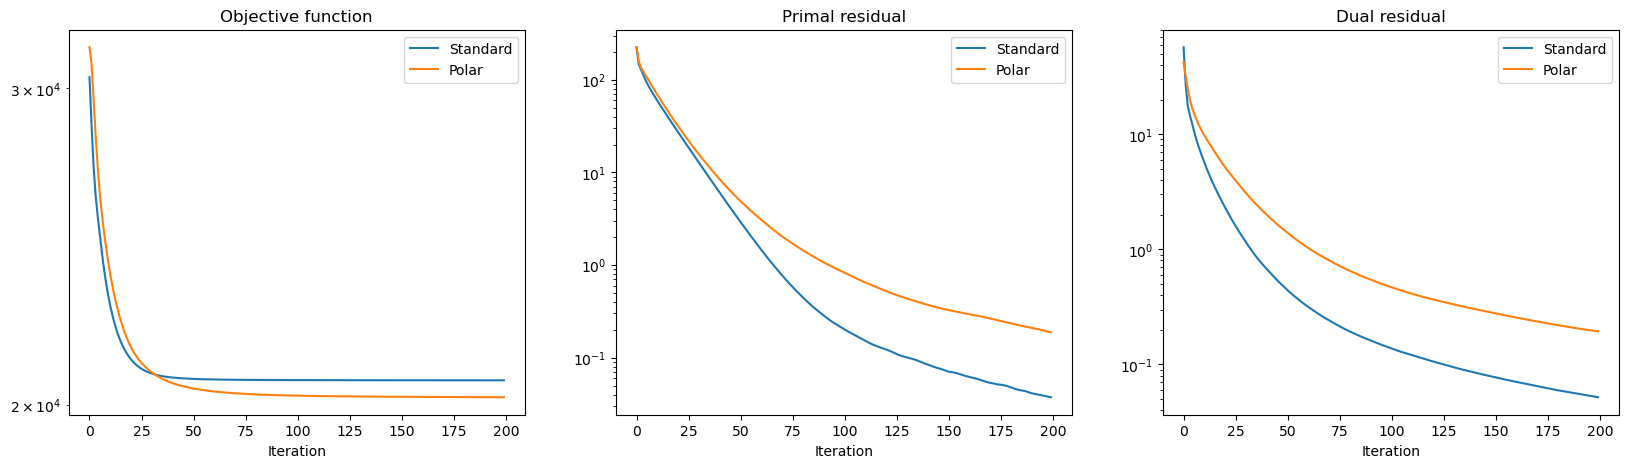

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_std, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_plr, title="Polar TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_std, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_plr, title="Polar TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()


fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(20, 5))
plot.plot(
    snp.vstack((hist_std.Objective, hist_plr.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("Standard", "Polar"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_std.Prml_Rsdl, hist_plr.Prml_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("Standard", "Polar"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_std.Dual_Rsdl, hist_plr.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("Standard", "Polar"),
    fig=fig,
    ax=ax[2],
)
fig.show()